# Load file

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

In [2]:
df_path = "C:/Users/Enduser/OneDrive - Asia Pacific University/uni/Y3S2/fyp/Model_trial/btc_trial_dataset2.csv"
dataset_df = pd.read_csv(df_path)

# Feature Selection: Dropping Irrelevant or Redundant Columns
 

In [3]:
drop_cols = ['tx_hash', 'is_malicious', 'all_malicious', 'mean_in_btc', 'mean_out_btc','in_malicious']
dataset_df.drop(columns=drop_cols, inplace=True)

In [4]:
dataset_df.head()

,indegree,outdegree,in_btc,out_btc,total_btc,out_malicious,out_and_tx_malicious
0,4,2,0.478187,0.476987,0.955174,0,0
1,3,2,2.019000,2.018500,4.037500,0,0
2,1,1,0.180100,0.180100,0.360200,0,0
3,1,2,5.879800,5.879300,11.759100,0,0
4,4,2,0.495906,0.495406,0.991312,0,0


# Data Splitting

In [5]:
from sklearn.model_selection import train_test_split

# Load dataset
X = dataset_df.drop('out_and_tx_malicious', axis=1)
y = dataset_df['out_and_tx_malicious']

# Split dataset into Train (80%) and Test (20%) ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Further split Train into Train (90%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

print("Data Split Complete:")
print(f"Train Size: {X_train.shape[0]}")
print(f"Validation Size: {X_val.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")


Data Split Complete:
Train Size: 72000
Validation Size: 8000
Test Size: 20000


# Feature Scaling: Logarithmic Transformation 

In [6]:

# Define features for log transformation
log_features = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc']

# Apply log transformation
for df in [X_train, X_val, X_test]:  
    df[log_features] = np.log1p(df[log_features])  # log1p avoids log(0)

print("Log Transformation Complete")
# View before and after log transformation for a sample feature
# feature_to_view = 'in_btc'

# print("\nBefore Log Transformation:")
# print(X_train[feature_to_view].head())

# print("\nAfter Log Transformation:")
# print(np.log1p(X_train[feature_to_view].head()))

Log Transformation Complete


# Feature Engineer

In [7]:
# Feature Engineering Function
def add_features(df):
    df['out_malicious_to_total_btc'] = df['out_malicious'] / (df['total_btc'] + 1e-6)
    df['log_total_btc'] = np.log1p(df['total_btc'])
    df['out_malicious_in_btc_interaction'] = df['out_malicious'] * df['in_btc']
    df['net_btc_flow'] = df['in_btc'] - df['out_btc']
    return df

# Apply feature engineering to Train, Validation, and Test sets
X_train_fe = add_features(X_train)
X_val_fe = add_features(X_val)
X_test_fe = add_features(X_test)

# Select the final set of features
selected_features = [
    'in_btc', 'out_btc', 'total_btc', 'out_malicious', 'indegree','outdegree',
    'out_malicious_to_total_btc', 'log_total_btc',
    'out_malicious_in_btc_interaction', 'net_btc_flow'
]

X_train_final = X_train_fe[selected_features]
X_val_final = X_val_fe[selected_features]
X_test_final = X_test_fe[selected_features]

print("Feature Engineering Complete")


Feature Engineering Complete


#  Data Balancing - Smote

In [8]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.01, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE:
out_and_tx_malicious
0    71923
1      719
Name: count, dtype: int64


# Feature Scaling: Robust Scaling

In [9]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform Train set
X_train_scaled = scaler.fit_transform(X_train_smote)

# Transform Validation and Test sets using the same scaler
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_final.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)

print("Scaling Complete")


Scaling Complete


-------------------------------------------

# XGBoost Model 1 (with Optuna tuning) 

[I 2025-04-02 20:35:22,604] A new study created in memory with name: no-name-7ceb7a68-afa3-4432-8a97-035caafbc158
[I 2025-04-02 20:35:25,114] Trial 0 finished with value: 0.07925407925407925 and parameters: {'max_depth': 5, 'learning_rate': 0.07687921001329358, 'n_estimators': 363, 'subsample': 0.9442535448115422, 'min_child_weight': 4, 'reg_alpha': 0.11859647860585162, 'reg_lambda': 0.014802347629358633, 'colsample_bytree': 0.9831735875303276}. Best is trial 0 with value: 0.07925407925407925.
[I 2025-04-02 20:35:26,018] Trial 1 finished with value: 0.029806259314456036 and parameters: {'max_depth': 3, 'learning_rate': 0.05469625164536103, 'n_estimators': 209, 'subsample': 0.7357044192897669, 'min_child_weight': 7, 'reg_alpha': 0.07914720413653281, 'reg_lambda': 0.06299679897018108, 'colsample_bytree': 0.9843869758657544}. Best is trial 0 with value: 0.07925407925407925.
[I 2025-04-02 20:35:27,264] Trial 2 finished with value: 0.012300810735253005 and parameters: {'max_depth': 3, 'lear

Best Parameters: {'max_depth': 6, 'learning_rate': 0.07819670518271708, 'n_estimators': 481, 'subsample': 0.8622313468419597, 'min_child_weight': 6, 'reg_alpha': 0.002555051195519531, 'reg_lambda': 4.260665659623047, 'colsample_bytree': 0.7778277044380473}
Optimal Threshold from Full Training: 0.807


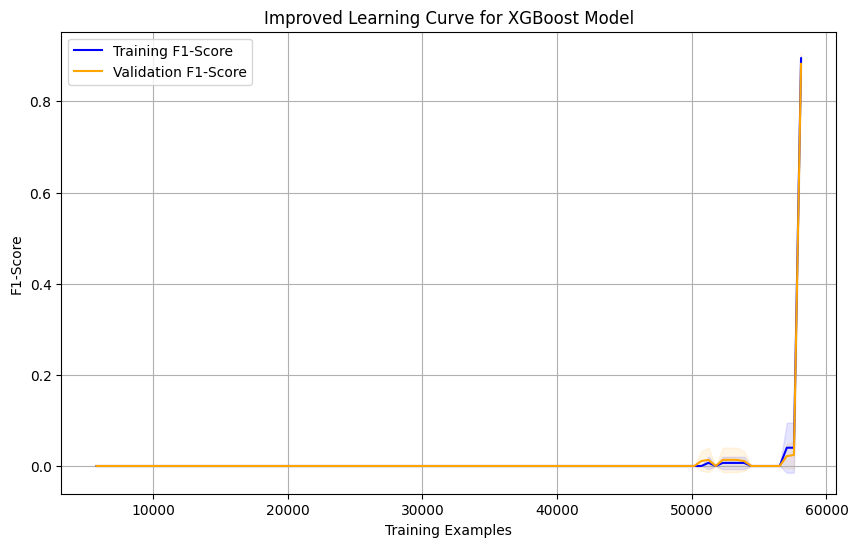


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.88      0.68      0.77        22

    accuracy                           1.00     20000
   macro avg       0.94      0.84      0.88     20000
weighted avg       1.00      1.00      1.00     20000

Final F1-Score (Fraud Class): 0.769


In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from xgboost import XGBClassifier
import optuna  # Bayesian optimization
from sklearn.metrics import confusion_matrix

# Compute scale_pos_weight for imbalance handling
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),    # L1 Regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),  # L2 Regularization
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train_smote)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    return f1_score(y_test, (y_pred_proba > 0.5).astype(int))  # Default threshold

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train final model with best parameters
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_scaled, y_train_smote)

# Determine optimal threshold
y_pred_proba_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold from Full Training: {optimal_threshold:.3f}")

# Custom scorer using the optimal threshold
def custom_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    return f1_score(y, y_pred)

# Learning Curve with StratifiedKFold
train_sizes = np.linspace(0.1, 1.0, 100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    xgb_model, X_train_scaled, y_train_smote,
    cv=cv, scoring=custom_scorer, n_jobs=-1,
    train_sizes=train_sizes
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1-Score', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation F1-Score', color='orange')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training Examples')
plt.ylabel('F1-Score')
plt.title('Improved Learning Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Final Model Evaluation
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Final F1-Score (Fraud Class): {f1_score(y_test, y_pred):.3f}")

In [57]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[19976     2]
 [    7    15]]


# Save model 1 (xgb_model)

In [ ]:
import joblib

joblib.dump(xgb_model, 'xgb_model.pkl')  
joblib.dump(scaler, 'scaler_xgb.pkl')      

# XGBoost Model 2 (Grid Search)

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Parameter grid for XGBoost hyperparameter tuning
param_grid = {
    'n_estimators': [50, 80, 100, 200],          # Number of trees
    'max_depth': [5, 10, 15, 20],                # Max depth of trees
    'learning_rate': [0.001, 0.01, 0.05, 0.1],   # Learning rate
    'subsample': [0.6, 0.8, 0.9, 1.0],           # Subsample ratio of training data
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],    # Column sample by tree
    'scale_pos_weight': [30, 50, 70],            # For handling class imbalance
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)

# Custom F1 scorer for optimization (focusing on fraud detection)
f1_scorer = make_scorer(f1_score, zero_division=0)

# Apply GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    xgb_model, param_grid, scoring=f1_scorer, cv=5, n_jobs=-1, verbose=2
)

# Fit Grid Search to training data
print("\nRunning Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train_scaled, y_train_smote)

# Get the best parameters found from GridSearchCV
best_params = grid_search.best_params_
print("\nBest Parameters Found:", best_params)

# Train final model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    random_state=42, n_jobs=-1, **best_params
)

best_xgb_model.fit(X_train_scaled, y_train_smote)

# Make predictions on the test set
y_pred_adjusted = best_xgb_model.predict(X_test_scaled_df)

# Evaluate performance on the test set
print("\nOptimized XGBoost Results with Threshold 0.89:")
print(classification_report(y_test, y_pred_adjusted, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix:")
print(conf_matrix)


Running Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits

Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50, 'scale_pos_weight': 30, 'subsample': 0.8}

Optimized XGBoost Results with Threshold 0.89:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.57      0.73      0.64        22

    accuracy                           1.00     20000
   macro avg       0.79      0.86      0.82     20000
weighted avg       1.00      1.00      1.00     20000


Confusion Matrix:
[[19966    12]
 [    6    16]]


 - learning curve

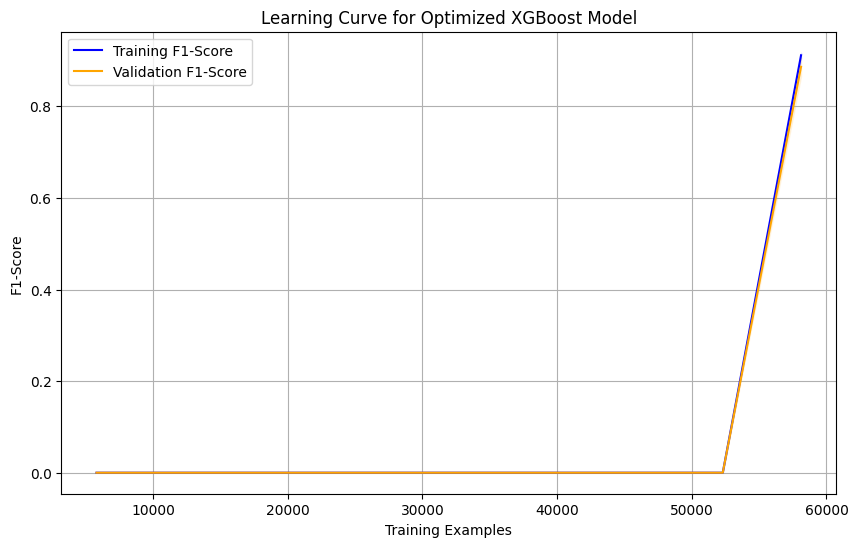

In [ ]:
best_xgb_model.fit(X_train_scaled, y_train_smote)

# Learning Curve with StratifiedKFold

train_sizes = np.linspace(0.1, 1.0, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_model, X_train_scaled, y_train_smote,
    cv=cv, scoring=f1_scorer, n_jobs=-1,
    train_sizes=train_sizes
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1-Score', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation F1-Score', color='orange')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training Examples')
plt.ylabel('F1-Score')
plt.title('Learning Curve for Optimized XGBoost Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Save model 2 

In [61]:
import joblib

joblib.dump(best_xgb_model, 'best_xgb_model.pkl')  
joblib.dump(scaler, 'scaler_xgb.pkl')      

['scaler_xgb.pkl']